# Kernels and estimators

This tutorial shows how to work with CellRank using the **low-level mode**. We will interact directly with CellRank's two main modules, [kernels](https://cellrank.readthedocs.io/en/stable/classes.html#kernels) and [estimators](https://cellrank.readthedocs.io/en/stable/classes.html#estimators). Don't worry - this really isn't any more complicated than using scikit-learn. 

We'll demonstrate this using a dataset of mouse pancreatic development at E15.5 <cite data-cite="bastidas-ponce:19">Bastidas-Ponce et al., Development 2019</cite>. We'll use scVelo a bit to work with RNA velocity, if you're unfamiliar with that, see the [documentation](https://scvelo.readthedocs.io/) or read <cite data-cite="bergen:20">Bergen et al., Nat. Biotechnol. 2020</cite>.

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/kernels_and_estimators.ipynb).

## Concept of kernels and estimators

<img src="_static/img/cellrank_software_package.png" width="600" alt="CellRank is structured into kernels and estimators">

The idea behind CellRank is to have a flexible and extensible [scanpy/AnnData](https://scanpy.readthedocs.io/en/latest/) compatible modeling framework for single-cell data that resolves around the concept of [Markov chains](https://en.wikipedia.org/wiki/Markov_chain). Each state in the Markov chain is given by one observed cell and transition probabilities among cells only depend on the current cell and not on the history. To make CellRank as flexible as possible, we modularized it into **kernels** which compute a cell-cell transition matrix and **estimators** which use the transition matrix formulate hypotheses about the underlying dynamics, see the above figure.  

**Kernels** read data from an [AnnData object](https://scanpy.readthedocs.io/en/latest/) like [RNA velocity vectors](https://scvelo.readthedocs.io/), [transcriptomic similarity](https://scanpy.readthedocs.io/en/latest/api/scanpy.pp.neighbors.html#scanpy.pp.neighbors), [spatial proximity](https://squidpy.readthedocs.io/en/latest/), [pseudotime](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.dpt.html#scanpy.tl.dpt), etc. and use it to compute a sparse transition matrix (see figure above). We set up the kernel structure so that it's easy for you to contribute your own kernel via CellRank's [external](https://cellrank.readthedocs.io/en/stable/external_api.html) module, check out our [create your own kernel tutorial](https://cellrank.readthedocs.io/en/stable/creating_new_kernel.html). 

**Estimators** read a cell-cell transition matrix from a kernel object and compute aggregate dynamics based on it. Each estimator works with every kernel - the core idea here is that **it does not matter how you computed your transition matrix** to run an estimator on top, you can even compute a transition matrix outside of CellRank and import it via a [PrecomputedKernel](https://cellrank.readthedocs.io/en/stable/classes.html#precomputed-kernel) - you will still be able to use every estimator on top. Our main estimator is called *Generalized Perron Cluster Cluster Analysis* (GPCCA) and we interface to the great [pyGPCCA library](https://pygpcca.readthedocs.io/en/latest/) for it, see <cite data-cite="reuter:18">Reuter et al., JCTC 2018</cite> and <cite data-cite="reuter:19">Reuter et al., JCP 2019</cite>.

Besides kernels and estimators, there are **downstream plotting functions** that use fate probabilities to do fun stuff, i.e. giving you a directed version of [PAGA](https://cellrank.readthedocs.io/en/stable/auto_examples/plotting/plot_directed_paga.html#sphx-glr-auto-examples-plotting-plot-directed-paga-py), plotting [gene expression trends](https://cellrank.readthedocs.io/en/stable/auto_examples/plotting/plot_gene_trends.html#sphx-glr-auto-examples-plotting-plot-gene-trends-py) along lineages or [embedding cells in a circle](https://cellrank.readthedocs.io/en/stable/auto_examples/plotting/plot_circular_embedding.html#sphx-glr-auto-examples-plotting-plot-circular-embedding-py) based on where they're likely to go - to name only a few. Check out CellRank's [API](https://cellrank.readthedocs.io/en/stable/api.html) and our [gallery](https://cellrank.readthedocs.io/en/stable/auto_examples/index.html) for a full list. 

This tutorial will focus on getting you familiar with the structure of kernels and estimators, how they can be used to set up and analyze a single-cell Markov chain and how you can extract real biological knowledge from them. If you would like to learn something about the **math behind them**, or see more biological applications, check out the CellRank preprint <cite data-cite="lange:20">Lange et al., bioRxiv 2020</cite>. Enjoy the tutorial!

## Import packages & data

Easiest way to start is to download [Miniconda3](https://docs.conda.io/en/latest/miniconda.html) along with the environment file found [here](https://raw.githubusercontent.com/theislab/cellrank_notebooks/master/environment.yml). To create the environment, run `conda create -f environment.yml`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

We'll not go trough all the pre-processing steps described in the [basic tutorial](https://cellrank.readthedocs.io/en/stable/cellrank_basics.html) again - instead, we will download an AnnData object that contains pre-processed (filtered, total counts normalized & log-transformed) data where RNA velocity has already been pre-computed for us. The following commands will download the pre-processed `adata` object and save it under `datasets/endocrinogenesis_day15.5_preprocessed.h5ad`. Beware - this object is about 150 MB large. 

In [3]:
adata = cr.datasets.pancreas_preprocessed()
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.81 0.19]


100%|██████████| 140M/140M [00:03<00:00, 37.5MB/s]


AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'diffmap_evals', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 

## Initialize a kernel

To construct a transition matrix, CellRank offers a number of kernel classes in `cellrank.tl.kernels`. To demonstrate the concept, we'll restrict our attention to the following two kernels here:


 - `VelocityKernel`: compute transition matrix based on RNA velocity.
 - `ConnectivityKernel`: compute symmetric transition matrix based on transcriptomic similarity - essentially a diffusion-pseudotime (DPT) kernel <cite data-cite="haghverdi:16">Haghverdi et al., Nature Methods 2016</cite>.
 

For a full list of kernels, check out our [API](https://cellrank.readthedocs.io/en/stable/api.html#kernels). To initialize a kernel object, simply run the following:

In [4]:
from cellrank.tl.kernels import VelocityKernel

vk = VelocityKernel(adata)

Note that kernels need an AnnData object to read data from it - CellRank is part of the [Scanpy/AnnData ecosystem](https://scanpy.readthedocs.io/en/latest/). The only exception to this is the [PrecomputedKernel](https://cellrank.readthedocs.io/en/stable/classes.html#precomputed-kernel) which directly accepts a transition matrix, thus making it possible to interface to CellRank from outside the scanpy/AnnData world. 

To learn more about our kernel object, we can print it:

In [5]:
print(vk)

<VelocityKernel>


There isn't very much here yet!

## Compute a transition matrix

To compute a transition matrix, every kernel object has a corresponding method:

In [6]:
vk.compute_transition_matrix()

Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode
Setting `softmax_scale=3.9741`
    Finish (0:00:03)


100%|██████████| 2531/2531 [00:01<00:00, 1988.79cell/s]


<VelocityKernel>

Which algorithm is run under the hood to get the cell-cell transition probabilities depends entirely on the kernel - in this case, we compared RNA velocity vectors to transcriptomic displacements in local neighborhoods to estimate where each single cell is likely to go. To see how exactly this transition matrix was computed, we can print the kernel again:

In [7]:
print(vk)

<VelocityKernel[softmax_scale=3.97, mode=deterministic, seed=27017, scheme=<CorrelationScheme>]>


There's a lot more info now! To find out what all of these mean, check the docstring of `.compute_transition_matrix`. The most important bits of information here are:

 - `mode='deterministic`: by default, the computation is deterministic, but we can also sample from the velocity distribution (`mode='sampling'`), get a 2nd order estimate (`mode='stochastic'`) or a Monte Carlo estimate (`mode='monte_carlo'`).
 - `backward=False`: run the process in the forward direction. To change this, set `backward=True` when initializing the `VelocityKernel`.
 - `softmax_scale`: scaling factor used in the softmax to transform cosine similarities into probabilities. The larger this value, the more centered the distribution will be around the most likely cell. If `None`, use velocity variances to scale the softmax, i.e. an automatic way to tune it in terms of local variance in velocities. This requires one additional run (always in 'deterministic' mode, to quickly estimate the scale).

## Combining two kernels

RNA velocity vectors can sometimes be very noisy - to regularize them, let's combine the `VelocityKernel` with a `ConnectivityKernel`, computed on the basis of transcriptomic similarity. Let's start by initializing such a kernel and computing a second transition matrix:

In [8]:
from cellrank.tl.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


The `ConnectivityKernel` has a parameter `conn_key` which is used to read the KNN graph from `adata.obsp`. By default, this is set to `connectivities`, meaning that a transcriptomic similarity-based KNN graph is used. If you have spatial data and you've processed in using squidpy <cite data-cite="palla:21">Palla et al., bioRxiv 2021</cite>, you can read a spatial-proximity based KNN graph by varying the `conn_key` to whatever was used to save the graph in squidpy, by default, `spatial_connectivities`. 

Note how it's possible to call the `.compute_transition_matrix` method direcly when initializing the kernel - this works for all kernel classes. Given these two kernels now, we can combine them with some relative weights:

In [9]:
combined_kernel = 0.8 * vk + 0.2 * ck

Let's print the `combined_kernel` to see what happened:

In [10]:
print(combined_kernel)

((0.8 * <VelocityKernel[softmax_scale=3.97, mode=deterministic, seed=27017, scheme=<CorrelationScheme>]>) + (0.2 * <ConnectivityKernel[dnorm=True, key=connectivities]>))


There we go, we took the two computed transition matrices stored in the kernel object and combined them using a weighted mean, with weights given by the factors we provided. We will use the `combined_kernel` in the `estimators` section below. 

## Initialize an estimator

Estimators take a `kernel` object and offer methods to analyze it. The main objective is to decompose the state space into a set of macrostates that represent the slow-time scale dynamics of the process. A subset of these macrostates will be the initial or terminal states of the process, the remaining states will be intermediate transient states. CellRank currently offers two estimator classes in `cellrank.tl.estimators`:

 - `CFLARE`: **C**lustering and **F**iltering **L**eft **A**nd **R**ight **E**igenvectors. Heuristic method based on the spectrum of the transition matrix.
 - `GPCCA`: **G**eneralized **P**erron **C**luster **C**luster **A**nalysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which maximizes the self-transition probability for the macrostates, see <cite data-cite="reuter:18">Reuter et al., JCTC 2018</cite> and <cite data-cite="reuter:19">Reuter et al., JCP 2019</cite>.
 
For more information on the estimators, have a look at the [API](https://cellrank.readthedocs.io/en/stable/api.html#estimators). We will demonstrate the `GPCCA` estimator here, however, the `CFLARE` estimator has a similar set of methods (which do different things internally). Let's start by initializing a `GPCCA` object based on the `combined_kernel` we constructed above:

In [11]:
from cellrank.tl.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[n=2531, kernel=((0.8 * <VelocityKernel[softmax_scale=3.97, mode=deterministic, seed=27017, scheme=<CorrelationScheme>]>) + (0.2 * <ConnectivityKernel[dnorm=True, key=connectivities]>))]


Additionally to the information about the kernel it is based on, this prints out the number of states in the underlying Markov chain. 

## Compute a matrix decomposition

GPCCA needs a real sorted [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition) to work with, so let's start by computing this and visualizing eigenvalues in complex plane:

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 10, 16, 18, 20]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:16)


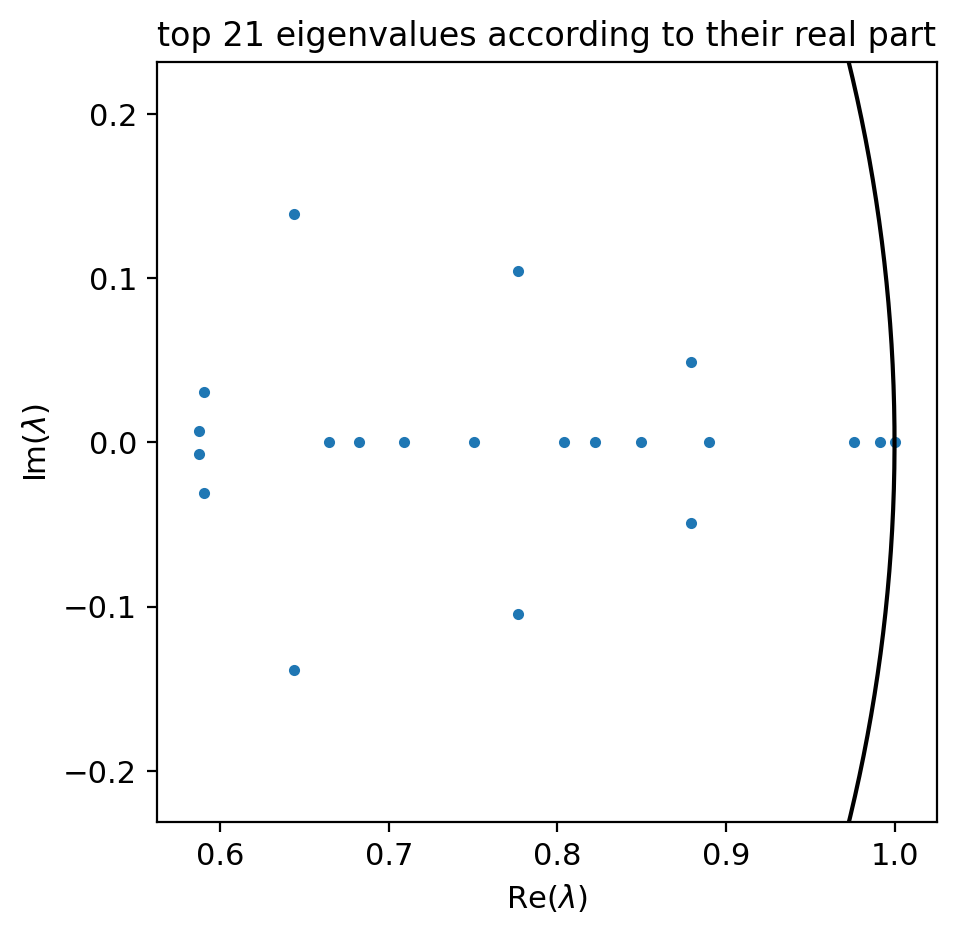

In [12]:
g.compute_schur(n_components=20)
g.plot_spectrum()

To compute the Schur decomposition, there are two methods implemented:

 - `method='brandts'`: use `scipy.linalg.schur` to compute a full real Schur decomposition and sort it <cite data-cite="brandts:02">Brandts, Numerical linear algebra with applications 2002</cite>. Note that `scipy.linalg.schur` only supports dense matrices, so consider using this for small cell numbers (<10k).
 - `method='krylov'`: use an iterative, krylov-subspace based algorithm provided in [SLEPc](https://slepc.upv.es/) to directly compute a partial, sorted, real Schur decomposition. This works with sparse matrices and will scale to extremely large cell numbers. 
 
The real Schur decomposition for transition matrix `T` is given by `Q U Q**(-1)`, where `Q` is orthogonal and `U` is quasi-upper triangular, which means it's upper triangular except for 2x2 blocks on the diagonal. 1x1 blocks on the diagonal represent real eigenvalues, 2x2 blocks on the diagonal represent complex eigenvalues. Above, we plotted the top 20 eigenvalues of the matrix `T` to see whether there is an apparent _eigengap_. In the present case, there seems to be such a gap after the first 3 eigenvalues.

Schur vectors will span an invariant subspace, let's call it `X` (Schur vectors in the columns). Note that the Schur decomposition is not unique - however, the subspace spanned by the top Schur vectors is unique so will be our initial & terminal states as well as fate probabilities. 

## Infer terminal states

The next step in `GPCCA` is to find a linear combination of these vectors such that the Markov chain defined on the subset of states has large self-transition probability. We do this by calling the following method:

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


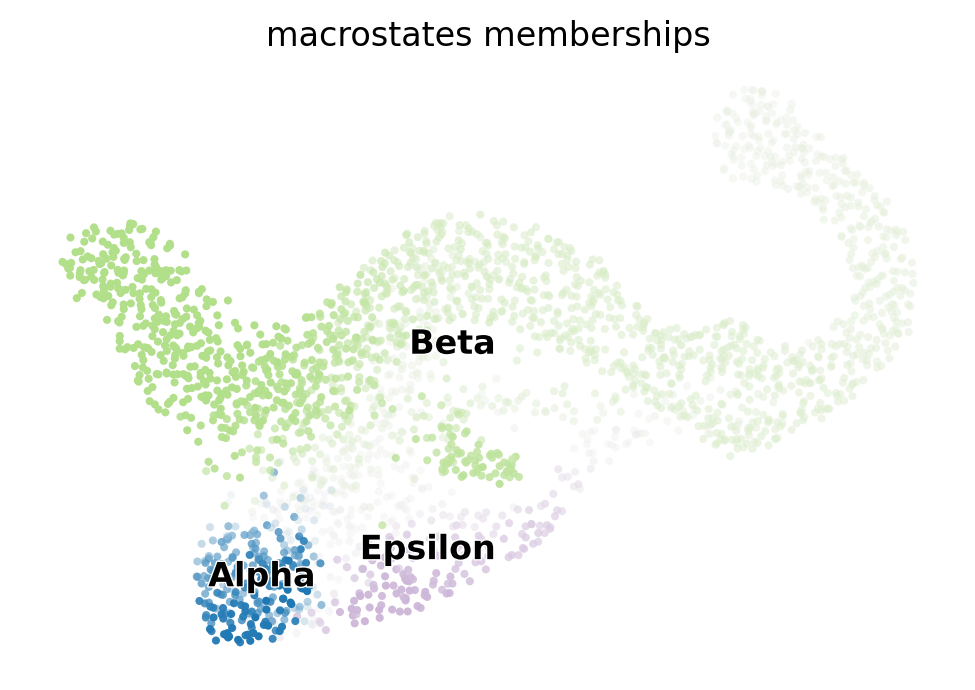

In [13]:
g.compute_macrostates(n_states=3, cluster_key="clusters")
g.plot_macrostates()

We can look at individual states by passing `same_plot=False`:

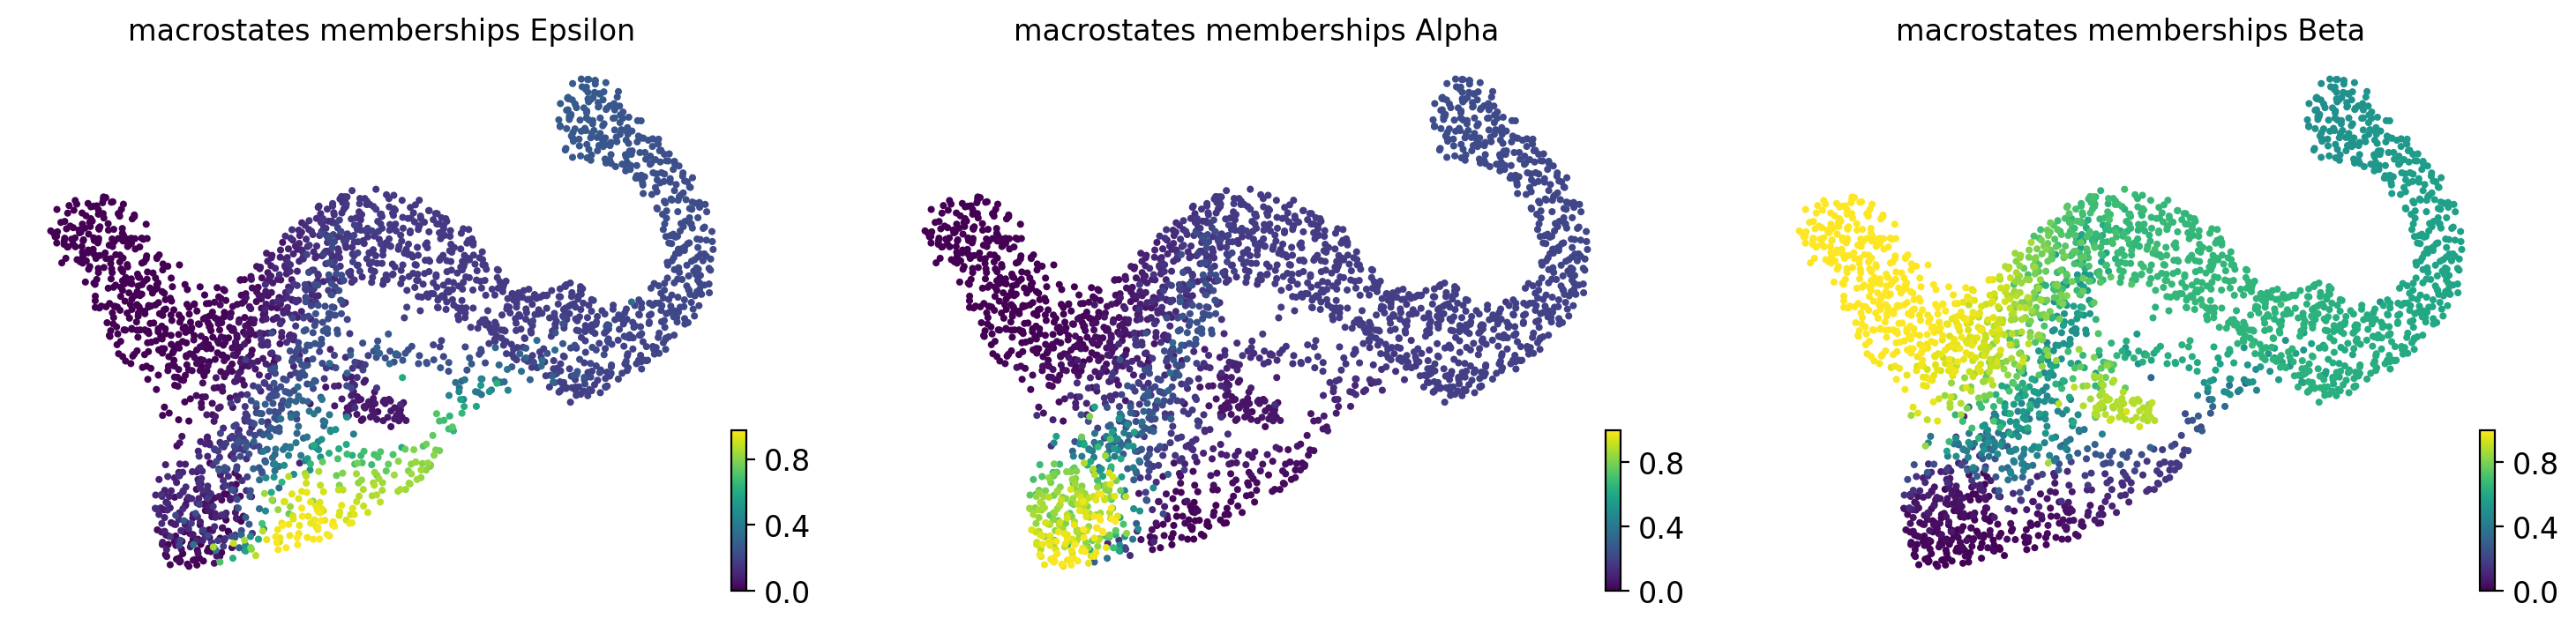

In [14]:
g.plot_macrostates(same_plot=False)

To see the most likely cells for each of the states, set `discrete=True`. This uses top `n` cells from each lineage, where `n` can be set in `compute_macrostates` (defaults to 30 cells).

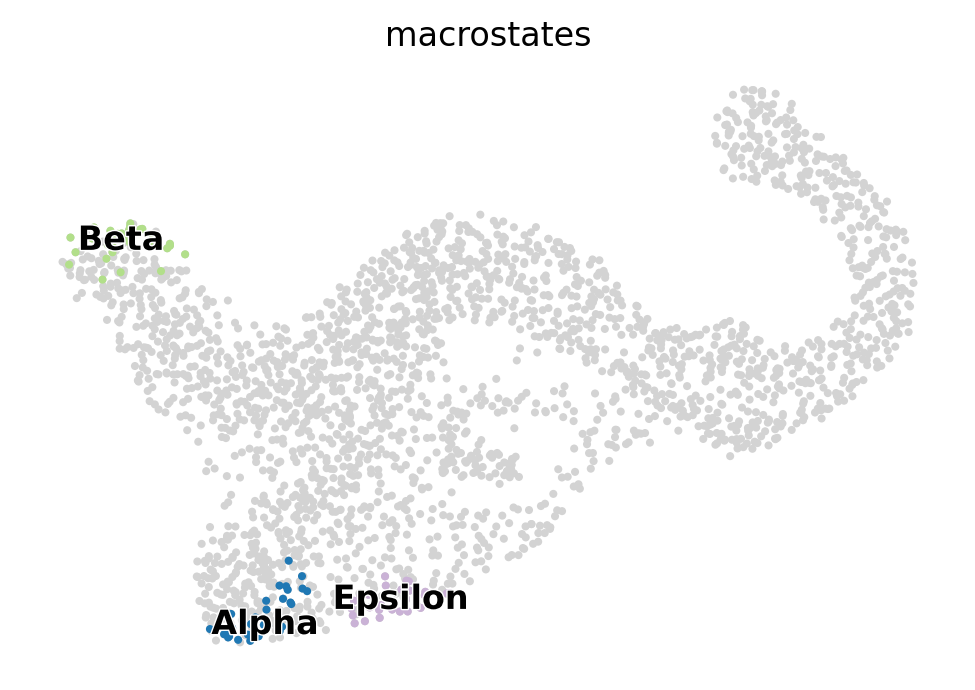

In [15]:
g.plot_macrostates(discrete=True)

So far, we have just computed macrostates. To restrict these to the set of terminal states, there are three possibilities:

- `estimator.compute_terminal_states()`: automatically selects the terminal states from the set of macrostates via a stability criterion.
- `estimator.set_terminal_states_from_macrostates()`: manually restrict the macrostates by passing a list of macrostate-names that you know are terminal in your data.
- `estimator.set_terminal_states`: manually set the terminal states, *without* computing macrostates, i.e. entirely manually. This is only recommended in situations where you're very certain where your terminal states are and you would just like to use the estimator to compute fate probabilities towards them. 

We'll use the automatic way below (it doesn't matter in this case since we have only computed three macrostates, and all of them are terminal):

In [16]:
g.compute_terminal_states()

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


## Estimate fate probabilities

Once we have computed the set of terminal states, we can compute fate probabilities towards them. We do this using [absorption probabilities](https://en.wikipedia.org/wiki/Absorbing_Markov_chain), an efficient way to compute where a cell is likely to end up if its transitions are described by a Markov chain. 

In [17]:
g.compute_absorption_probabilities()

Computing absorption probabilities
Defaulting to `'gmres'` solver.
Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


100%|██████████| 3/3 [00:00<00:00, 42.16/s]


If you have a large dataset, make sure you:

- use the [PETSc libary](https://www.mcs.anl.gov/petsc/) by setting `use_petsc=True`.
- parallelize your computations via the `n_jobs` parameter if you're looking at many temrinal states (>5)
- use the iterative [GMRES solver](https://en.wikipedia.org/wiki/Generalized_minimal_residual_method) via `solver='gmres'`.

CellRank's implementation of absorption probabilities is **extremely fast and memory efficient** - in our own experiments, it takes us about 2min to compute absorption probabilities for 100k cells towards 3 terminal states (30 cells each) using  an Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz with 32 cores with a peak memory usage of 35 about GiB. These experiments were run in CellRank 1.3 - version 1.4 includes an additional **speedup by a factor 5**. 

## Find driver genes

Once we have computed the `absorption_probabilities`, we can correlate them against all genes to find potential lineage drivers. Below, we show how to do this for just one terminal state. Note that results are written to the `.var` attribute of `adata`:

In [18]:
alpha_drivers = g.compute_lineage_drivers(lineages="Alpha", return_drivers=True)
alpha_drivers.sort_values(by="Alpha_corr", ascending=False)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


,Alpha_corr,Alpha_pval,Alpha_qval,Alpha_ci_low,Alpha_ci_high
index,,,,,
Gcg,0.866434,0.000000e+00,0.000000e+00,0.856381,0.875829
Irx2,0.519011,8.995140e-184,8.995140e-181,0.489957,0.546913
Peg10,0.515418,1.097612e-180,7.317414e-178,0.486221,0.543467
Wnk3,0.482773,1.796353e-154,8.981766e-152,0.452319,0.512103
Tmsb15l,0.456858,8.031014e-136,3.212406e-133,0.425470,0.487149
...,...,...,...,...,...
Nkx6-1,-0.313250,1.023609e-59,9.305533e-58,-0.347965,-0.277677
Nnat,-0.318837,5.915477e-62,6.226818e-60,-0.353409,-0.283396
Gng12,-0.324200,3.760078e-64,4.423621e-62,-0.358632,-0.288887


To find genes which may be involved in fate choice early on, we could restrict the correlation to a subset of our clusters using the `cluster_key` and `clusters` parameters. Let's take a look at some of the identified putative Alpha lineage drivers:

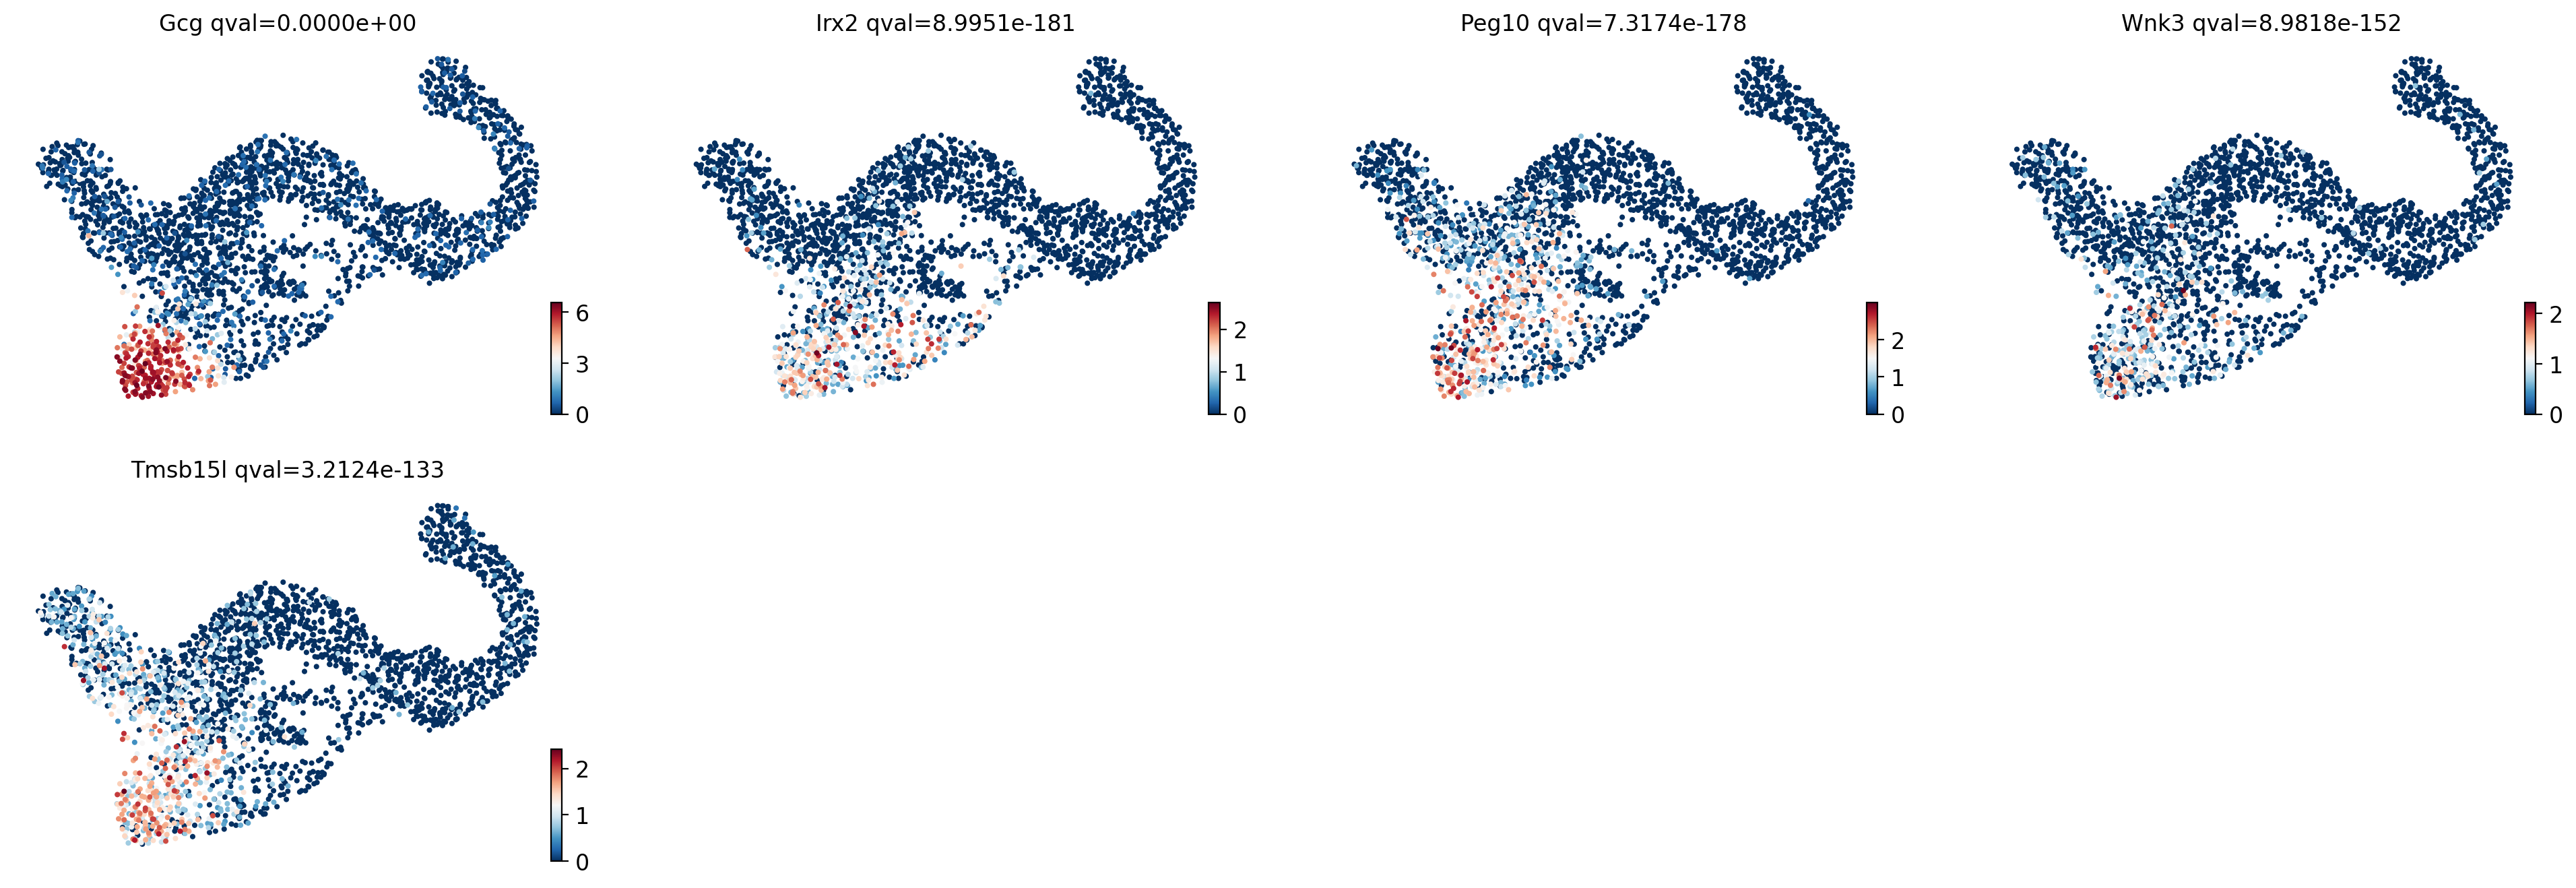

In [19]:
g.plot_lineage_drivers("Alpha", n_genes=5)

## Use a downstream plotting function

That's it for kernels and estimators already! In the last part, we'll demonstrate how a downstream plotting function can be used to visualize fate probabilities. Note that we won't call this though the estimator interface but though CellRank's plotting API. This works because estimators write to AnnData and downstream plotting functions read from AnnData. 

The function we're using here computes a circular projection of our dataset by arranging the terminal states around the unit circle and placing cell inside, depending on their fate probabilities. This is inspired by STEMNET <cite data-cite="velten:17">Velten et al., Nature Cell Biology 2017</cite>. 

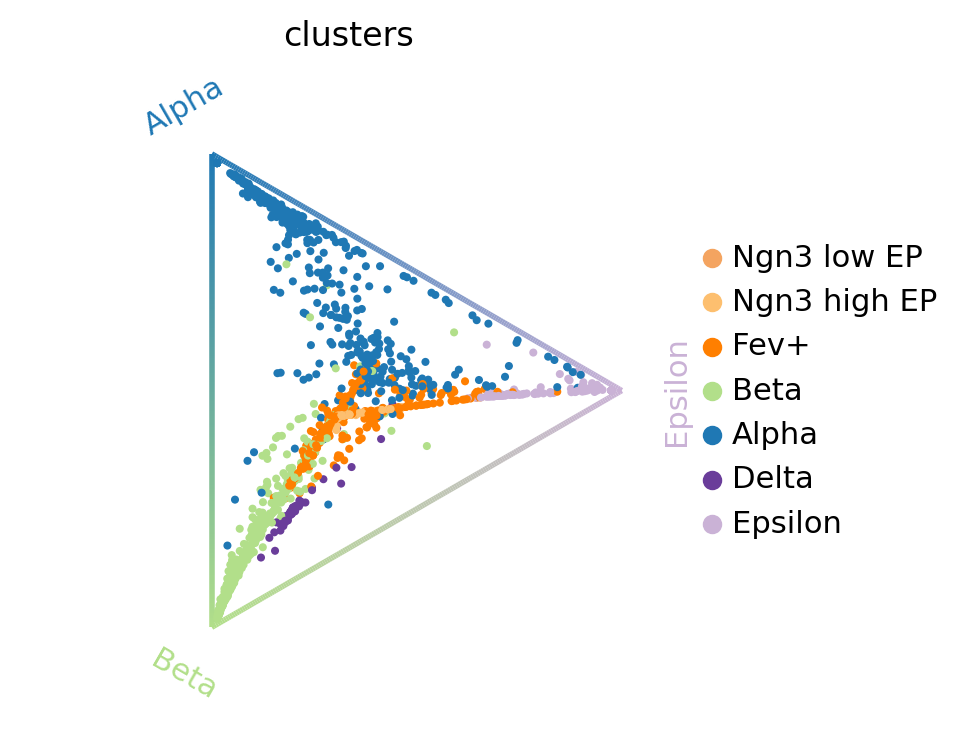

In [20]:
cr.pl.circular_projection(adata, keys="clusters", legend_loc="right")

## What's next?

Congrats! You made it though our kernels & estimators tutorial and you're now familiar with the structure of CellRank. I hope we were able to show you how you can use kernels to compute transition probabilities and estimators to analyze them. If you want to learn more about how to:

- compute **initial states** by simply repeating the above analysis passing `backward=True` to the kernel object when initializing it. The estimator object can be initialized as above with no changes needed.
- experiment with some of our **kernels and estimators** to build your own transition matrix and analyze it. Check the [API](https://cellrank.readthedocs.io/en/stable/api.html) for a full list of kernels and estimators and check the [gallery](https://cellrank.readthedocs.io/en/stable/auto_examples/index.html) to see them in action.
- learn how to use CellRank when you don't have RNA velocity information by following our [CellRank beyond RNA velocity](https://cellrank.readthedocs.io/en/stable/beyond_rna_velocity.html) tutorial.
- open an [issue](https://github.com/theislab/cellrank/issues/new/choose) if something is unclear or does not work for you.
- contribute your own kernel, check our [contributions guide](https://github.com/theislab/cellrank/blob/master/CONTRIBUTING.rst) and our [Creating a new kernel tutorial](https://cellrank.readthedocs.io/en/stable/creating_new_kernel.html).